In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

# Combine external features
city_name = "Beijing"
city_data = data[data['city'] == city_name].copy()
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')
city_data['day_of_year'] = city_data['date'].dt.dayofyear
city_data['month'] = city_data['date'].dt.month

# Aggregate the data by day
daily_data = city_data.groupby('date')['value'].sum().reset_index()

# Add external features
daily_data['day_of_year'] = daily_data['date'].dt.dayofyear
daily_data['month'] = daily_data['date'].dt.month

# Normalize the carbon emission data
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data_scaled = scaler.fit_transform(daily_data[['value']])

# Combine the normalized emissions with external features
features = np.concatenate([
    daily_data_scaled,
    daily_data[['day_of_year', 'month']].values
], axis=1)

# Prepare the data for GRU input (using sequences of 60 days)
sequence_length = 100
X_train, y_train = [], []

for i in range(sequence_length, len(features)):
    X_train.append(features[i-sequence_length:i, :])
    y_train.append(features[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Build the GRU model with external features
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.1))
gru_model.add(GRU(units=50, return_sequences=False))
gru_model.add(Dropout(0.1))
gru_model.add(Dense(units=25))
gru_model.add(Dense(units=1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_model.fit(X_train, y_train, batch_size=64, epochs=10)

# Prepare test data for prediction
test_input_gru = features[-sequence_length:]  # Start with the last 60 days of data
X_test_gru = []

for i in tqdm(range(365*2)):  # Predict for 1095 days (3 years)
    current_input = test_input_gru[-sequence_length:].reshape(1, sequence_length, X_train.shape[2])
    pred_value_gru = gru_model.predict(current_input)
    X_test_gru.append(pred_value_gru[0][0])

    # Update the input sequence with predicted value and external features
    next_day = (test_input_gru[-1, 1:] + [1, 1]) % [365, 12]  # Increment day and month
    next_input = np.concatenate([[pred_value_gru[0][0]], next_day], axis=0)
    test_input_gru = np.vstack([test_input_gru, next_input])[1:]

# Inverse transform the predicted values to the original scale
predicted_values_gru = scaler.inverse_transform(np.array(X_test_gru).reshape(-1, 1))

# Create a DataFrame with the predicted values
future_dates = pd.date_range(start=daily_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=1095)
predicted_df_gru = pd.DataFrame(predicted_values_gru, index=future_dates, columns=['Predicted Emissions'])

# Plotting the predicted emissions with GRU model
plt.figure(figsize=(14, 8))
plt.plot(daily_data['date'], daily_data['value'], label='Historical Emissions')
plt.plot(predicted_df_gru.index, predicted_df_gru['Predicted Emissions'], label='Predicted Emissions (GRU with External Features)', color='purple')
plt.title('Daily Carbon Emissions Prediction for Melbourne (Next 3 Years) - GRU Model with External Features')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50


/home/aster/miniconda3/envs/BayesOPt/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2386 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0346 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0281 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0210 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0194 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0191 - learning_rate: 0.0010
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0181 - learning_rate: 0.0010
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0155 - learning_rate: 0.0010
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0153 - learning_rate: 0.0010
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0143 - learning_rate: 0.0010
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0139 - learning_rate: 0.0010
Epoch 12/50
30/30 ━

  0%|          | 0/730 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

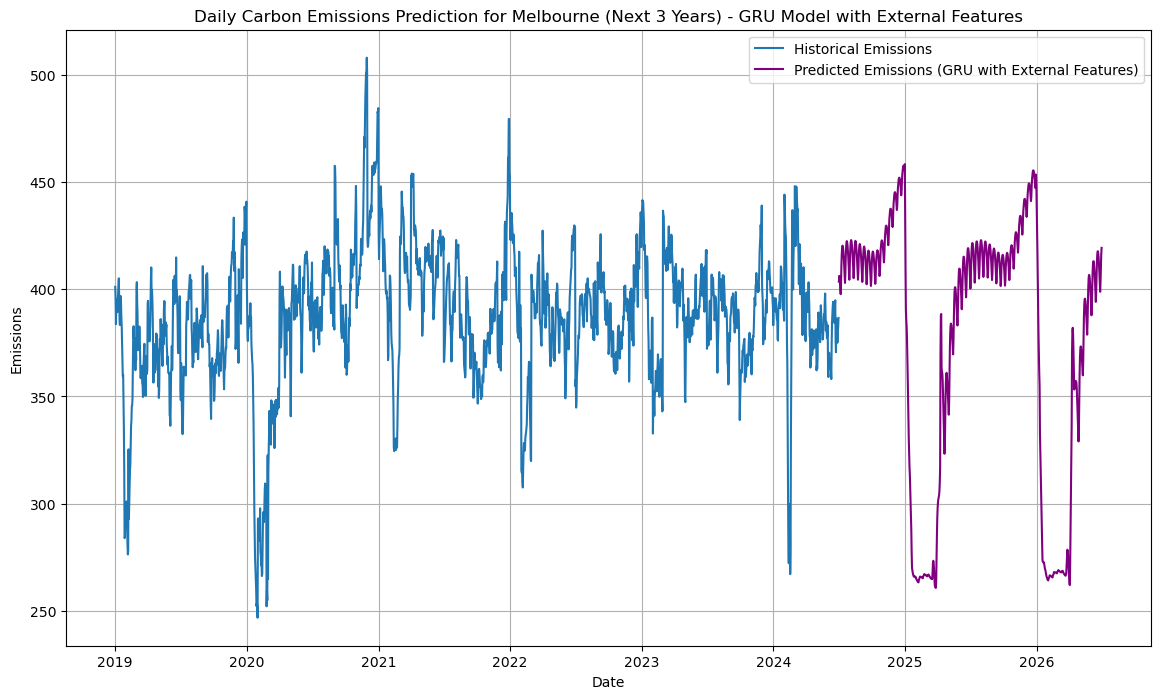

In [18]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

# Combine external features
city_name = "Beijing"
city_data = data[data['city'] == city_name].copy()
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')
city_data['day_of_year'] = city_data['date'].dt.dayofyear
city_data['month'] = city_data['date'].dt.month

# Aggregate the data by day
daily_data = city_data.groupby('date')['value'].sum().reset_index()

# Add external features
daily_data['day_of_year'] = daily_data['date'].dt.dayofyear
daily_data['month'] = daily_data['date'].dt.month

# Normalize the carbon emission data
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data_scaled = scaler.fit_transform(daily_data[['value']])

# Combine the normalized emissions with external features
features = np.concatenate([
    daily_data_scaled,
    daily_data[['day_of_year', 'month']].values
], axis=1)

# Prepare the data for GRU input (using sequences of 60 days)
sequence_length = 100
X_train, y_train = [], []

for i in range(sequence_length, len(features)):
    X_train.append(features[i-sequence_length:i, :])
    y_train.append(features[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Build the GRU model with external features
gru_model = Sequential()
gru_model.add(Bidirectional(GRU(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.1))
gru_model.add(Bidirectional(GRU(units=64, return_sequences=False)))
gru_model.add(Dropout(0.1))
gru_model.add(Dense(units=25, activation='relu'))
gru_model.add(Dense(units=1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='loss', patience=10)

# Train the model
gru_model.fit(X_train, y_train, batch_size=64, epochs=50, callbacks=[reduce_lr, early_stopping])

# Prepare test data for prediction
test_input_gru = features[-sequence_length:]  # Start with the last 60 days of data
X_test_gru = []

for i in tqdm(range(365*2)):  # Predict for 1095 days (3 years)
    current_input = test_input_gru[-sequence_length:].reshape(1, sequence_length, X_train.shape[2])
    pred_value_gru = gru_model.predict(current_input)
    X_test_gru.append(pred_value_gru[0][0])

    # Update the input sequence with predicted value and external features
    next_day = (test_input_gru[-1, 1:] + [1, 1]) % [365, 12]  # Increment day and month
    next_input = np.concatenate([[pred_value_gru[0][0]], next_day], axis=0)
    test_input_gru = np.vstack([test_input_gru, next_input])[1:]

# Inverse transform the predicted values to the original scale
predicted_values_gru = scaler.inverse_transform(np.array(X_test_gru).reshape(-1, 1))

# Create a DataFrame with the predicted values
future_dates = pd.date_range(start=daily_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=730)
predicted_df_gru = pd.DataFrame(predicted_values_gru, index=future_dates, columns=['Predicted Emissions'])

# Plotting the predicted emissions with GRU model
plt.figure(figsize=(14, 8))
plt.plot(daily_data['date'], daily_data['value'], label='Historical Emissions')
plt.plot(predicted_df_gru.index, predicted_df_gru['Predicted Emissions'], label='Predicted Emissions (GRU with External Features)', color='purple')
plt.title('Daily Carbon Emissions Prediction for Melbourne (Next 3 Years) - GRU Model with External Features')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()